## Example -- IEA Wind 740-10-MW

**IEA Wind TCP Task 55: The IEA Wind 740-10-MW Reference Offshore Wind Plants**

<https://www.osti.gov/biblio/2333634/>

This notebook uses `optiwindnet` to route the collector system cables for the two wind power plants presented in the report above.

This example requires an additional package:

`pip install pyyaml-include`

In [1]:
from pathlib import Path
import numpy as np
import yaml
import yaml_include

In [23]:
from optiwindnet.interarraylib import L_from_site, G_from_S, as_normalized
from optiwindnet.svg import svgplot
from optiwindnet.mesh import make_planar_embedding
from optiwindnet.pathfinding import PathFinder
from optiwindnet.interface import assign_cables
from optiwindnet.MILP import solver_factory, ModelOptions
from optiwindnet.baselines.hgs import iterative_hgs_cvrp

### Load layouts from files

In [3]:
# Wind farms stored according to the windIO format
# https://windio.readthedocs.io/en/latest/

yaml.add_constructor(
    "!include", yaml_include.Constructor(base_dir='data'))

def load_windIO(filepath):
    fpath = Path(filepath)
    with open(fpath, 'r') as f:
        system = yaml.full_load(f)
    coords = (system['wind_farm']['layouts']['initial_layout']
              ['coordinates'])
    terminalC = np.c_[coords['x'], coords['y']]
    coords = system['wind_farm']['electrical_substations']['coordinates']
    rootC = np.c_[coords['x'], coords['y']]
    coords = system['site']['boundaries']['polygons'][0]
    borderC = np.c_[coords['x'], coords['y']]
    T = terminalC.shape[0]
    R = rootC.shape[0]
    name_tokens = fpath.stem.split('_')
    return L_from_site(
        R=R, T=T,
        VertexC=np.vstack((terminalC, borderC, rootC)),
        border=np.arange(T, T + borderC.shape[0]),
        name=' '.join(name_tokens),
        handle=(f'{name_tokens[0].lower()}_'
                f'{name_tokens[1][:4].lower()}_'
                f'{name_tokens[2][:3].lower()}'),
    )

In [4]:
L_reg = load_windIO('data/IEA37_Borssele_Regular_System.yaml')

In [5]:
L_irr = load_windIO('data/IEA37_Borssele_Irregular_System.yaml')

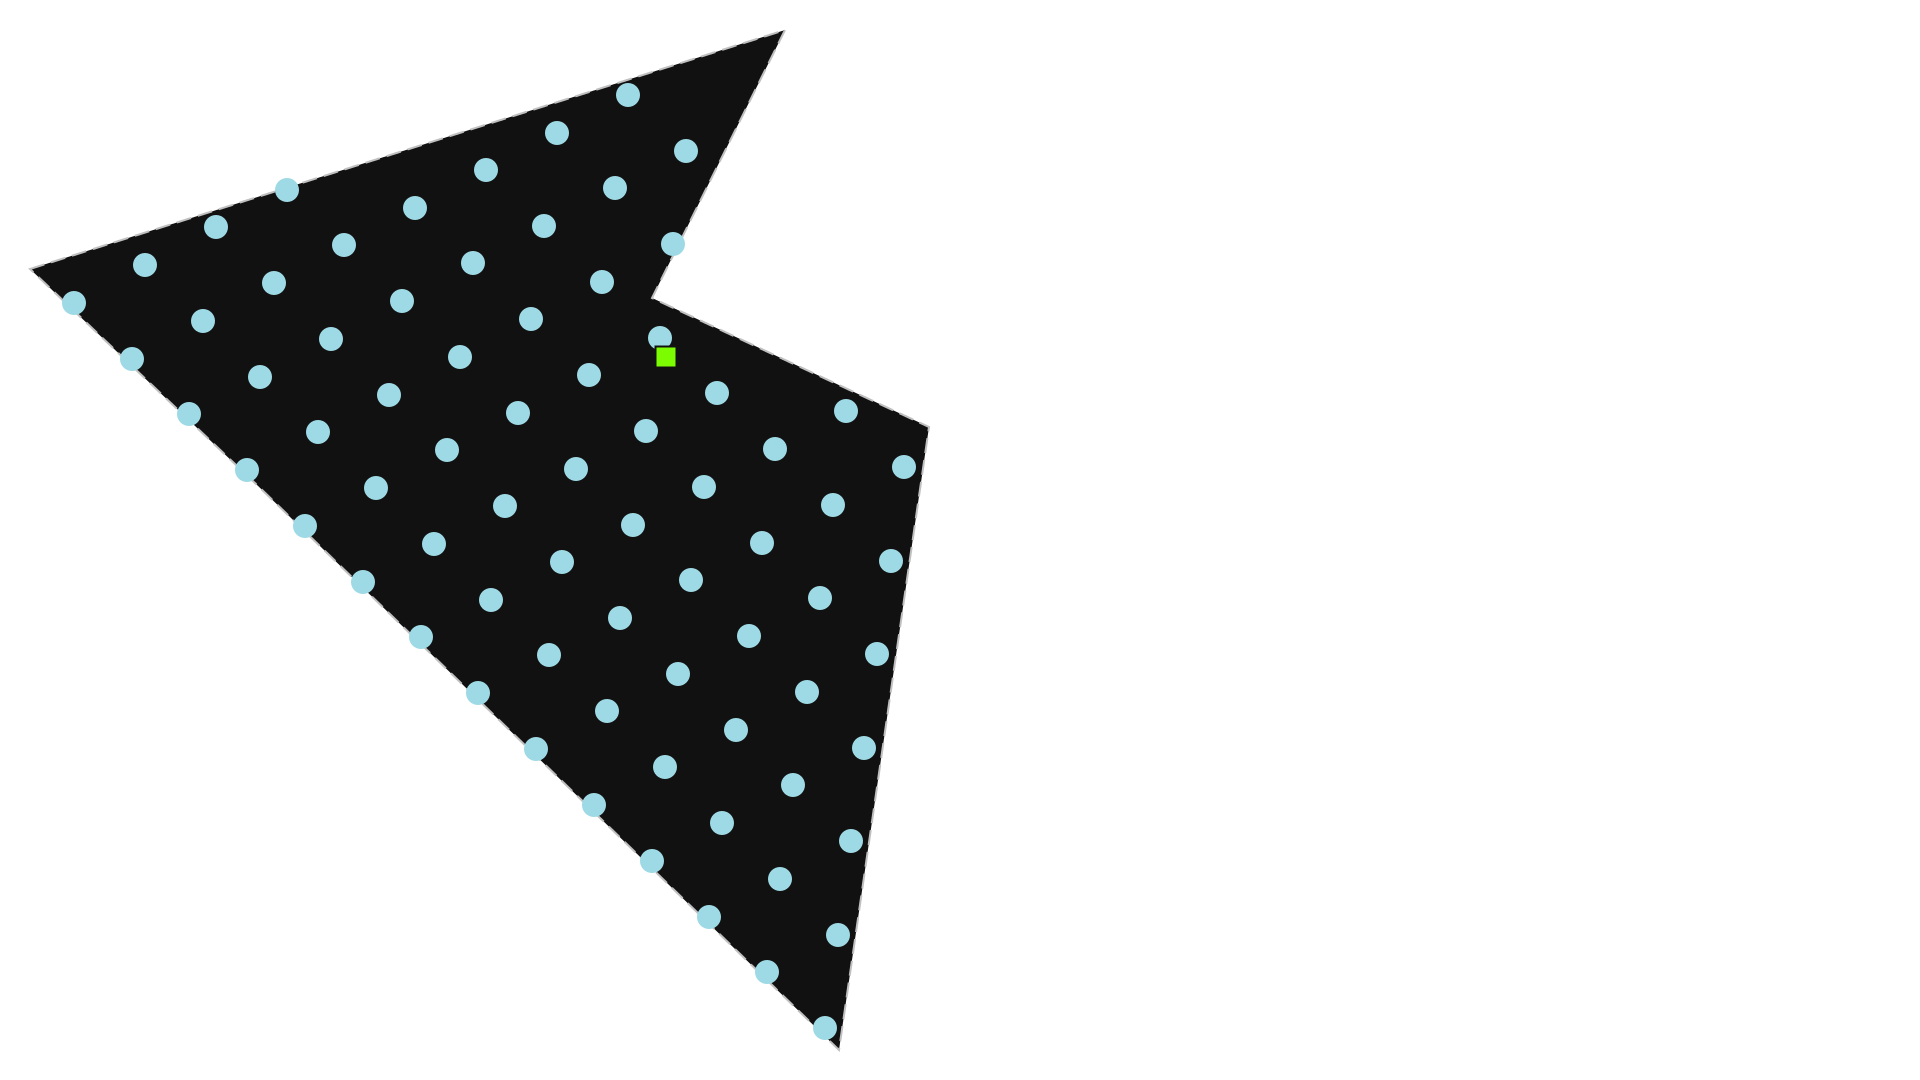

In [6]:
svgplot(L_reg)

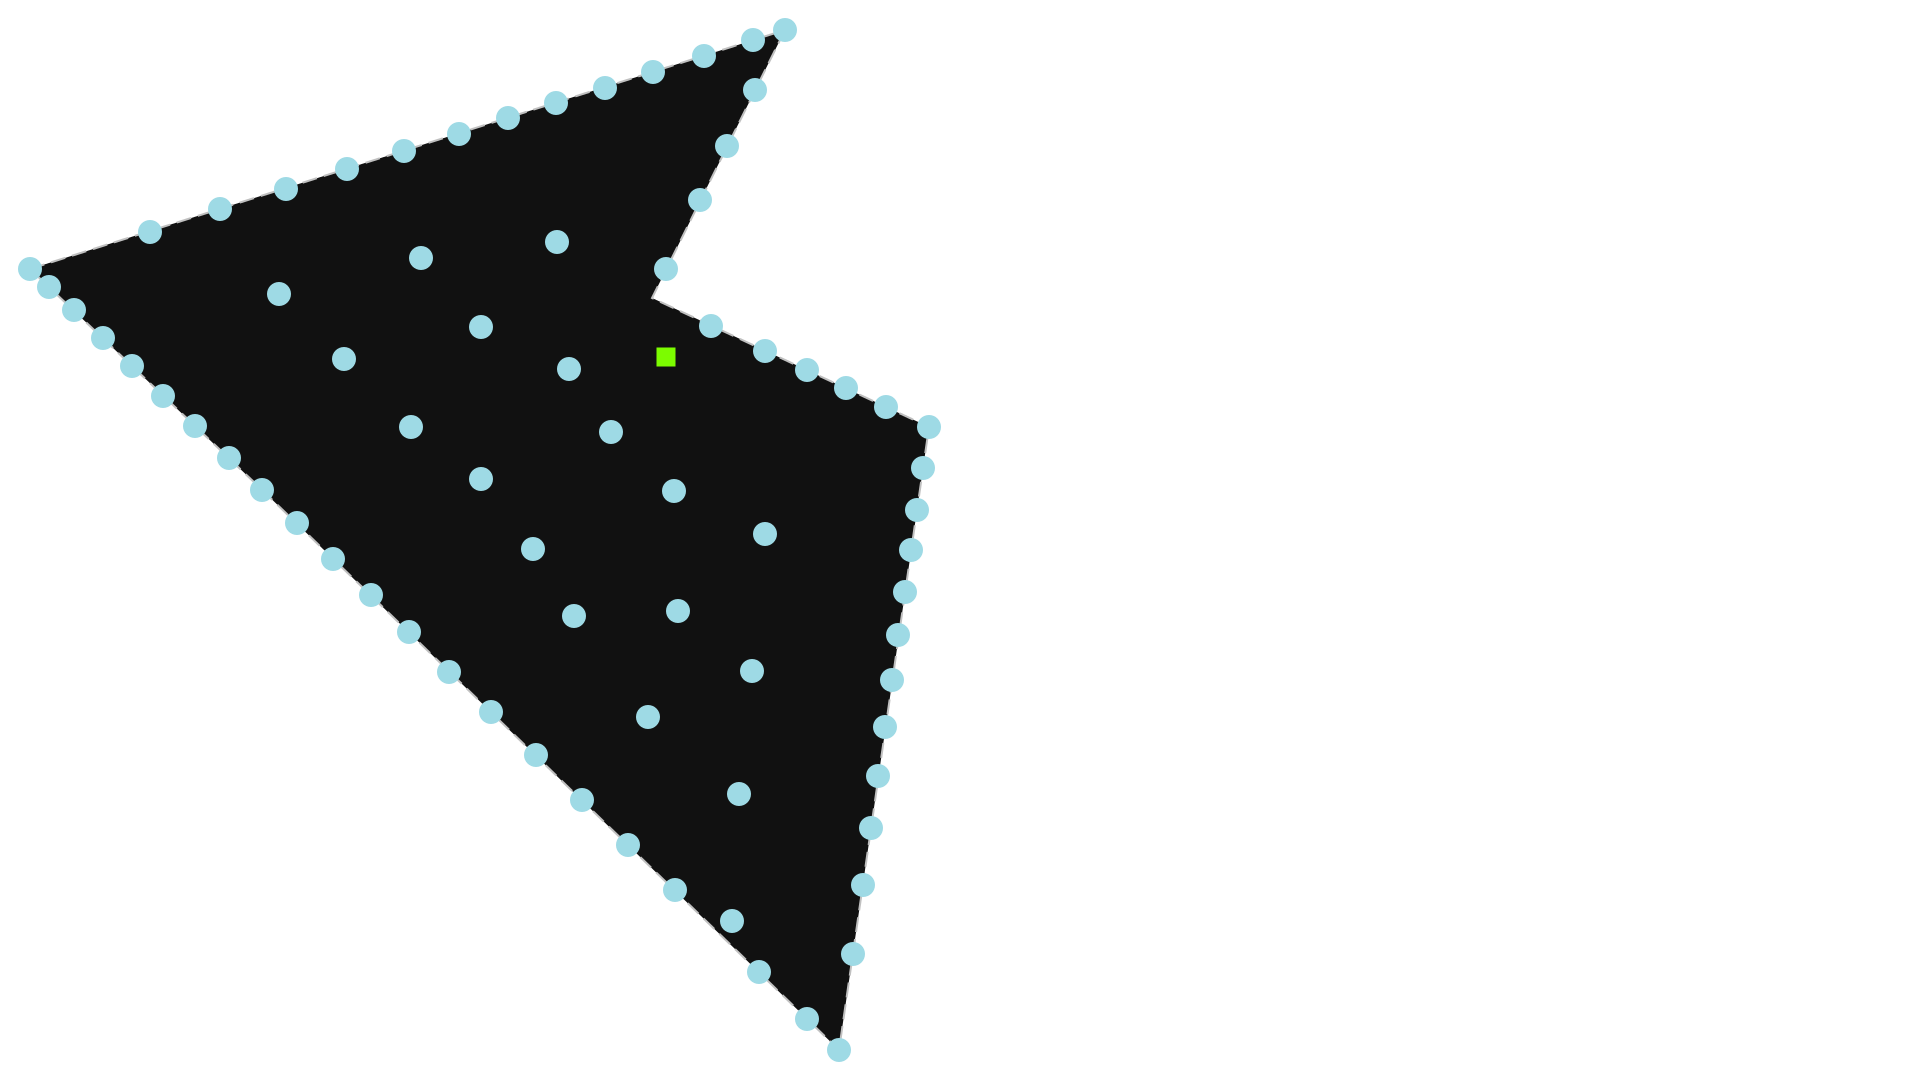

In [7]:
svgplot(L_irr)

### Additional design parameters

In [8]:
cable_costs = [206, 287, 406]  # [€/m] Costs per distance for each cable type
turbines_per_cable = [3, 5, 7]

In [9]:
cables = [(capacity, cost) for capacity, cost in zip(turbines_per_cable, cable_costs)]
capacity = max(turbines_per_cable)

### Choose the OR-Tools CP-Sat solver

In [10]:
solver = solver_factory('ortools')

### Regular layout

In [11]:
P, A = make_planar_embedding(L_reg)

In [12]:
# This meta-heuristic call is iterative and the time_limit applies
# to each iteration. About 97% of instances use a single iteration.
S_warm = iterative_hgs_cvrp(as_normalized(A), capacity=capacity, time_limit=1)

Check the total length of the warm-start solution:

In [13]:
G_reg_warm = G_from_S(S_warm, A)
G_reg_warm.size(weight='length')

139656.4789599965

In [16]:
solver.set_problem(
    P, A,
    capacity=G_reg_warm.graph['capacity'],
    model_options=ModelOptions(
        topology="branched",
        feeder_route="segmented",
        feeder_limit="unlimited",
    ),
    warmstart=G_reg_warm,
)

In [17]:
# required to get the log inside the notebook (goes only to console otherwise)
solver.solver.log_callback = print

solver.solve(
    mip_gap=0.005,
    time_limit=5,
    verbose=True,
)


Starting CP-SAT solver v9.13.4784
Parameters: max_time_in_seconds: 5 log_search_progress: true relative_gap_limit: 0.005
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x4383029b9db7c926)
#Variables: 1'540 (#bools: 770 in floating point objective) (1'392 primary variables)
  - 770 Booleans in [0,1]
  - 696 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 615 (#literals: 1'926)
#kLinear1: 1'540 (#enforced: 1'540)
#kLinear3: 2
#kLinearN: 223 (#terms: 3'844)

Starting presolve at 0.01s
The solution hint is complete, but it is infeasible! we will try to repair it.
[Scaling] Floating point objective has 770 terms with magnitude in [440.736, 14559.3] average = 2880.02
[Scaling] Objective coefficient relative error: 6.70633e-10
[Scaling] Objective worst-case absolute error: 7.704e-05
[Scaling] Objective scaling factor: 1.04858e+06
  8.95e-04s  0.00e+00d  [DetectDominanceRelations] 
  2.16e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoi

SolutionInfo(runtime=5.124953700000001, bound=136577.79897074128, objective=139645.18265364, relgap=0.021965553158440843, termination='FEASIBLE')

In [18]:
S_reg, G_reg = solver.get_solution()

In [19]:
assign_cables(G_reg, cables)
G_reg.size(weight='cost')

40714260.58298516

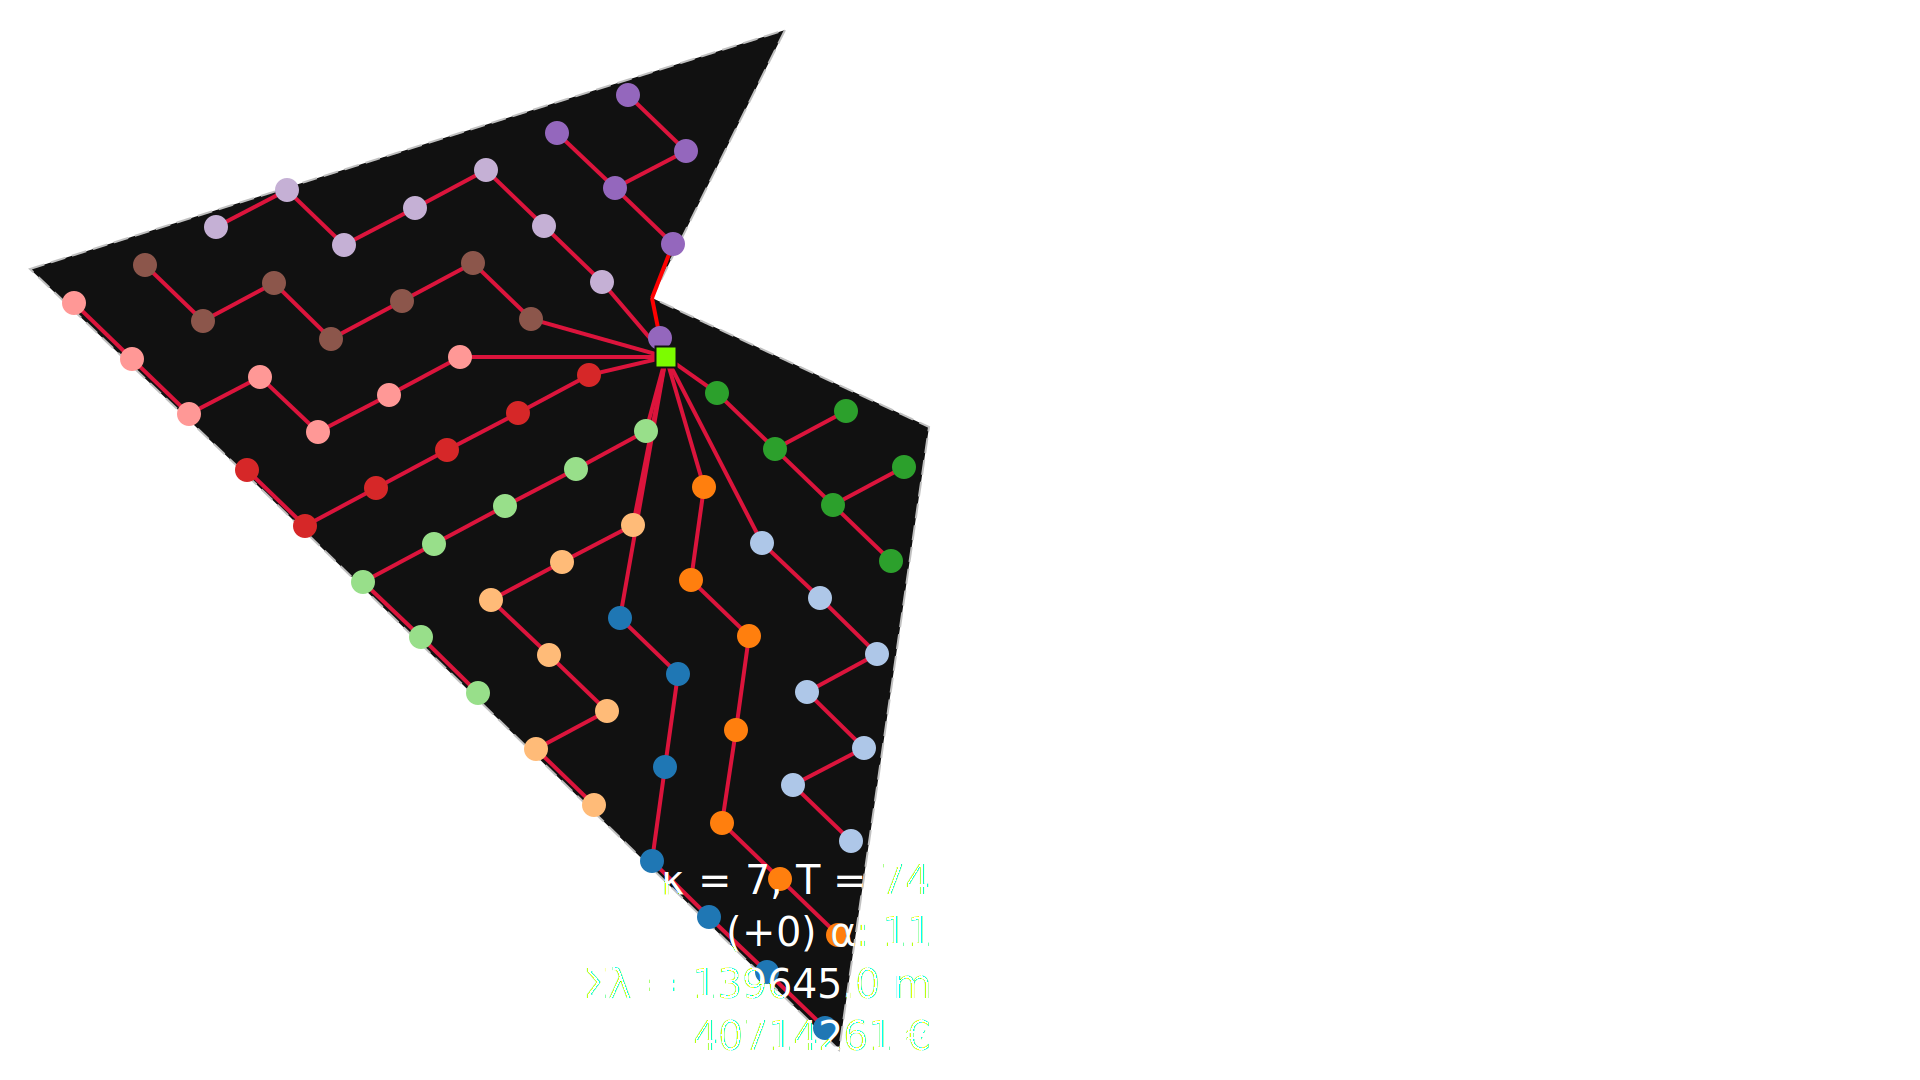

In [20]:
svgplot(G_reg)

### Irregular layout

In [21]:
P, A = make_planar_embedding(L_irr)

In [24]:
# This meta-heuristic call is iterative and the time_limit applies
# to each iteration. About 97% of instances use a single iteration.
S_warm = iterative_hgs_cvrp(as_normalized(A), capacity=capacity, time_limit=3)

Check the total length of the warm-start solution:

In [25]:
G_irr_warm = G_from_S(S_warm, A)
G_irr_warm.size(weight='length')

136451.2768186806

In [26]:
solver.set_problem(
    P, A,
    capacity=G_irr_warm.graph['capacity'],
    model_options=ModelOptions(
        topology="branched",
        feeder_route="segmented",
        feeder_limit="unlimited",
    ),
    warmstart=G_irr_warm,
)

In [27]:
# required to get the log inside the notebook (goes only to console otherwise)
solver.solver.log_callback = print

solver.solve(
    mip_gap=0.005,
    time_limit=300,
    verbose=True,
)


Starting CP-SAT solver v9.13.4784
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x68b2e1d9c4c26564)
#Variables: 1'192 (#bools: 596 in floating point objective) (1'044 primary variables)
  - 596 Booleans in [0,1]
  - 522 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 419 (#literals: 1'216)
#kLinear1: 1'192 (#enforced: 1'192)
#kLinear2: 4
#kLinear3: 5
#kLinearN: 216 (#terms: 2'957)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 596 terms with magnitude in [539.378, 15073.7] average = 3460.13
[Scaling] Objective coefficient relative error: 4.51281e-10
[Scaling] Objective worst-case absolute error: 7.28067e-05
[Scaling] Objective scaling factor: 1.04858e+06
  5.46e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.25e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver::PresolveToFixPoint] #num_loops=

SolutionInfo(runtime=300.5127943, bound=132347.12145358368, objective=134786.79225812532, relgap=0.018100221569703367, termination='FEASIBLE')

In [28]:
S_irr, G_irr = solver.get_solution()

In [29]:
assign_cables(G_irr, cables)
G_irr.size(weight='cost')

43091183.191651106

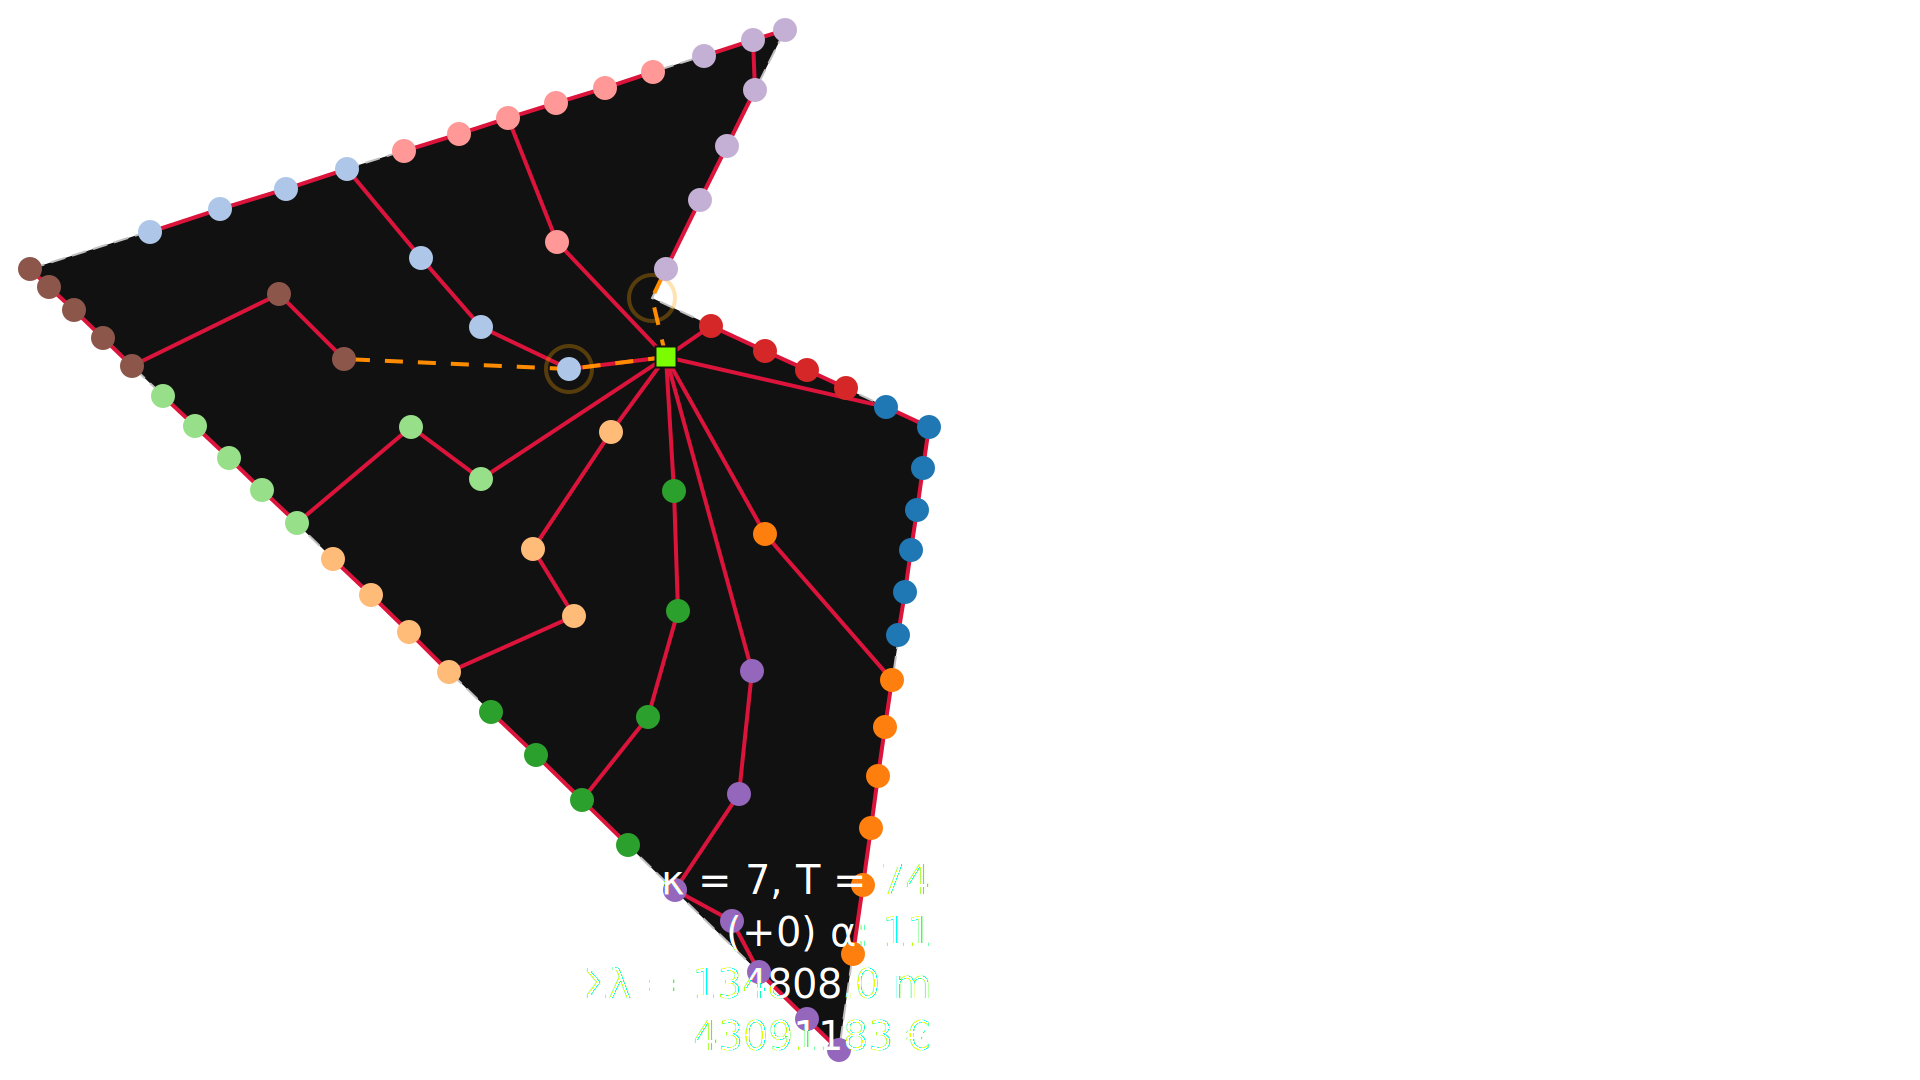

In [30]:
svgplot(G_irr)

### Layouts' edge list

These lists of 3-tuples has all the edges and their cable type (as an index to the `turbines_per_cable` list), i.e. (coordinate_A, coordinate_B, cable_type).

Negative node indices represent substations, the node indices ranging from 0 to 73 represent the WT in the order they were given.

If the layout has contours or detours, indices will go beyond the number of coordinates (WT, SS, borders) provided, and the mapping of these additional indices to indices to the provided coordinates is presented.

In [31]:
G_reg.edges(data='cable')

EdgeDataView([(72, 71, 0), (73, 66, 0), (67, 57, 2), (67, 68, 1), (68, 69, 1), (45, -1, 2), (45, 44, 1), (65, 66, 1), (65, 80, 1), (18, 19, 0), (26, 17, 1), (26, 25, 1), (44, 31, 0), (44, 43, 0), (33, -1, 2), (33, 23, 2), (70, 61, 0), (70, 63, 0), (61, 69, 0), (5, 4, 0), (5, 9, 1), (10, 11, 0), (51, 62, 0), (51, 60, 1), (62, 53, 0), (8, 14, 0), (8, 3, 0), (9, 15, 1), (40, 29, 0), (41, 52, 0), (41, 54, 0), (14, 22, 1), (22, 23, 1), (39, 52, 1), (39, 50, 1), (34, 25, 2), (34, -1, 2), (57, -1, 2), (66, 71, 0), (53, 64, 0), (15, 24, 2), (19, 28, 0), (3, 2, 0), (6, 7, 0), (11, 16, 0), (16, 17, 0), (-1, 56, 2), (-1, 47, 2), (-1, 46, 2), (-1, 24, 2), (-1, 58, 2), (-1, 32, 2), (-1, 49, 2), (46, 35, 2), (27, 28, 0), (27, 36, 1), (36, 35, 1), (48, 37, 1), (48, 47, 1), (7, 12, 0), (12, 13, 0), (42, 31, 0), (59, 58, 2), (59, 60, 1), (38, 29, 0), (38, 37, 0), (20, 13, 1), (20, 21, 1), (49, 50, 2), (21, 32, 2), (31, 30, 0), (0, 1, 0), (1, 4, 0), (56, 80, 1), (54, 55, 0)])

Mapping of contour/detour node to the index of its VertexC coordinate :

In [32]:
if G_reg.graph.get('C') or G_reg.graph.get('D'):
    R, T, B = (G_reg.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in G_reg.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 76}


In [33]:
G_irr.edges(data='cable')

EdgeDataView([(15, 21, 0), (15, 3, 0), (21, 66, 0), (58, 65, 0), (58, 61, 1), (65, 48, 0), (65, 47, 0), (16, 29, 1), (16, 17, 0), (29, 53, 1), (36, 62, 0), (36, 35, 0), (62, 69, 1), (42, 8, 1), (42, 25, 2), (37, 51, 1), (37, 20, 1), (70, 67, 2), (70, -1, 2), (5, 9, 0), (5, 32, 0), (10, 24, 0), (40, 55, 0), (40, 57, 0), (41, -1, 2), (41, 51, 2), (34, 1, 0), (34, 20, 0), (49, 54, 2), (49, -1, 2), (53, 28, 2), (46, 50, 0), (46, 44, 0), (22, 67, 1), (22, 44, 1), (23, 43, 0), (43, 7, 0), (31, 26, 0), (31, 56, 0), (56, 30, 1), (68, 14, 1), (68, 73, 2), (13, 26, 0), (-1, 60, 2), (-1, 55, 1), (-1, 39, 2), (-1, 28, 2), (-1, 33, 2), (-1, 25, 2), (-1, 80, 2), (-1, 81, 2), (71, 64, 2), (71, 81, 2), (64, 61, 1), (27, 52, 0), (27, 38, 0), (52, 59, 0), (60, 59, 2), (3, 12, 1), (50, 0, 0), (9, 19, 0), (11, 18, 0), (45, 33, 2), (45, 12, 1), (2, 8, 1), (2, 7, 0), (73, 80, 2), (69, 63, 1), (57, 72, 0), (39, 63, 2), (32, 14, 1), (18, 59, 0), (17, 24, 0), (6, 35, 0), (54, 30, 1), (20, 4, 0)])

Mapping of contour/detour node to the index of its VertexC coordinate :

In [34]:
if G_irr.graph.get('C') or G_irr.graph.get('D'):
    R, T, B = (G_irr.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in G_irr.graph['fnT'][T + B:-R]),
        start=T + B
    )))

{80: 28, 81: 76}
